# Poverty detection with machine learning from space

In this study, we hope to use the above satellite image spectral bands and image feature to separate neighborhood from the poorest to richest in Rwanda. For specific methodology, we are going to use **transfer learning** Convolutional Neural Networks. The pre-trained model is VGG16, and of course, you can switch to other neural net architectures. 

## Hypothesis

People in the more impoverished neighborhood are:

- living in smaller houses in dense residential areas;
- less accessibility from main road networks;
- less green space;
- more unpaved area;
- drier > less running and drinking water.
- less night time activities which reflect in nightlight imagery with dimmer light at night.

We queried three data sources for this study: Sentinel-2A, SNP VIIRS night-time light, and USAID DHS household survey. The workflow to query and extract the data sources have been simplified as the following diagram.


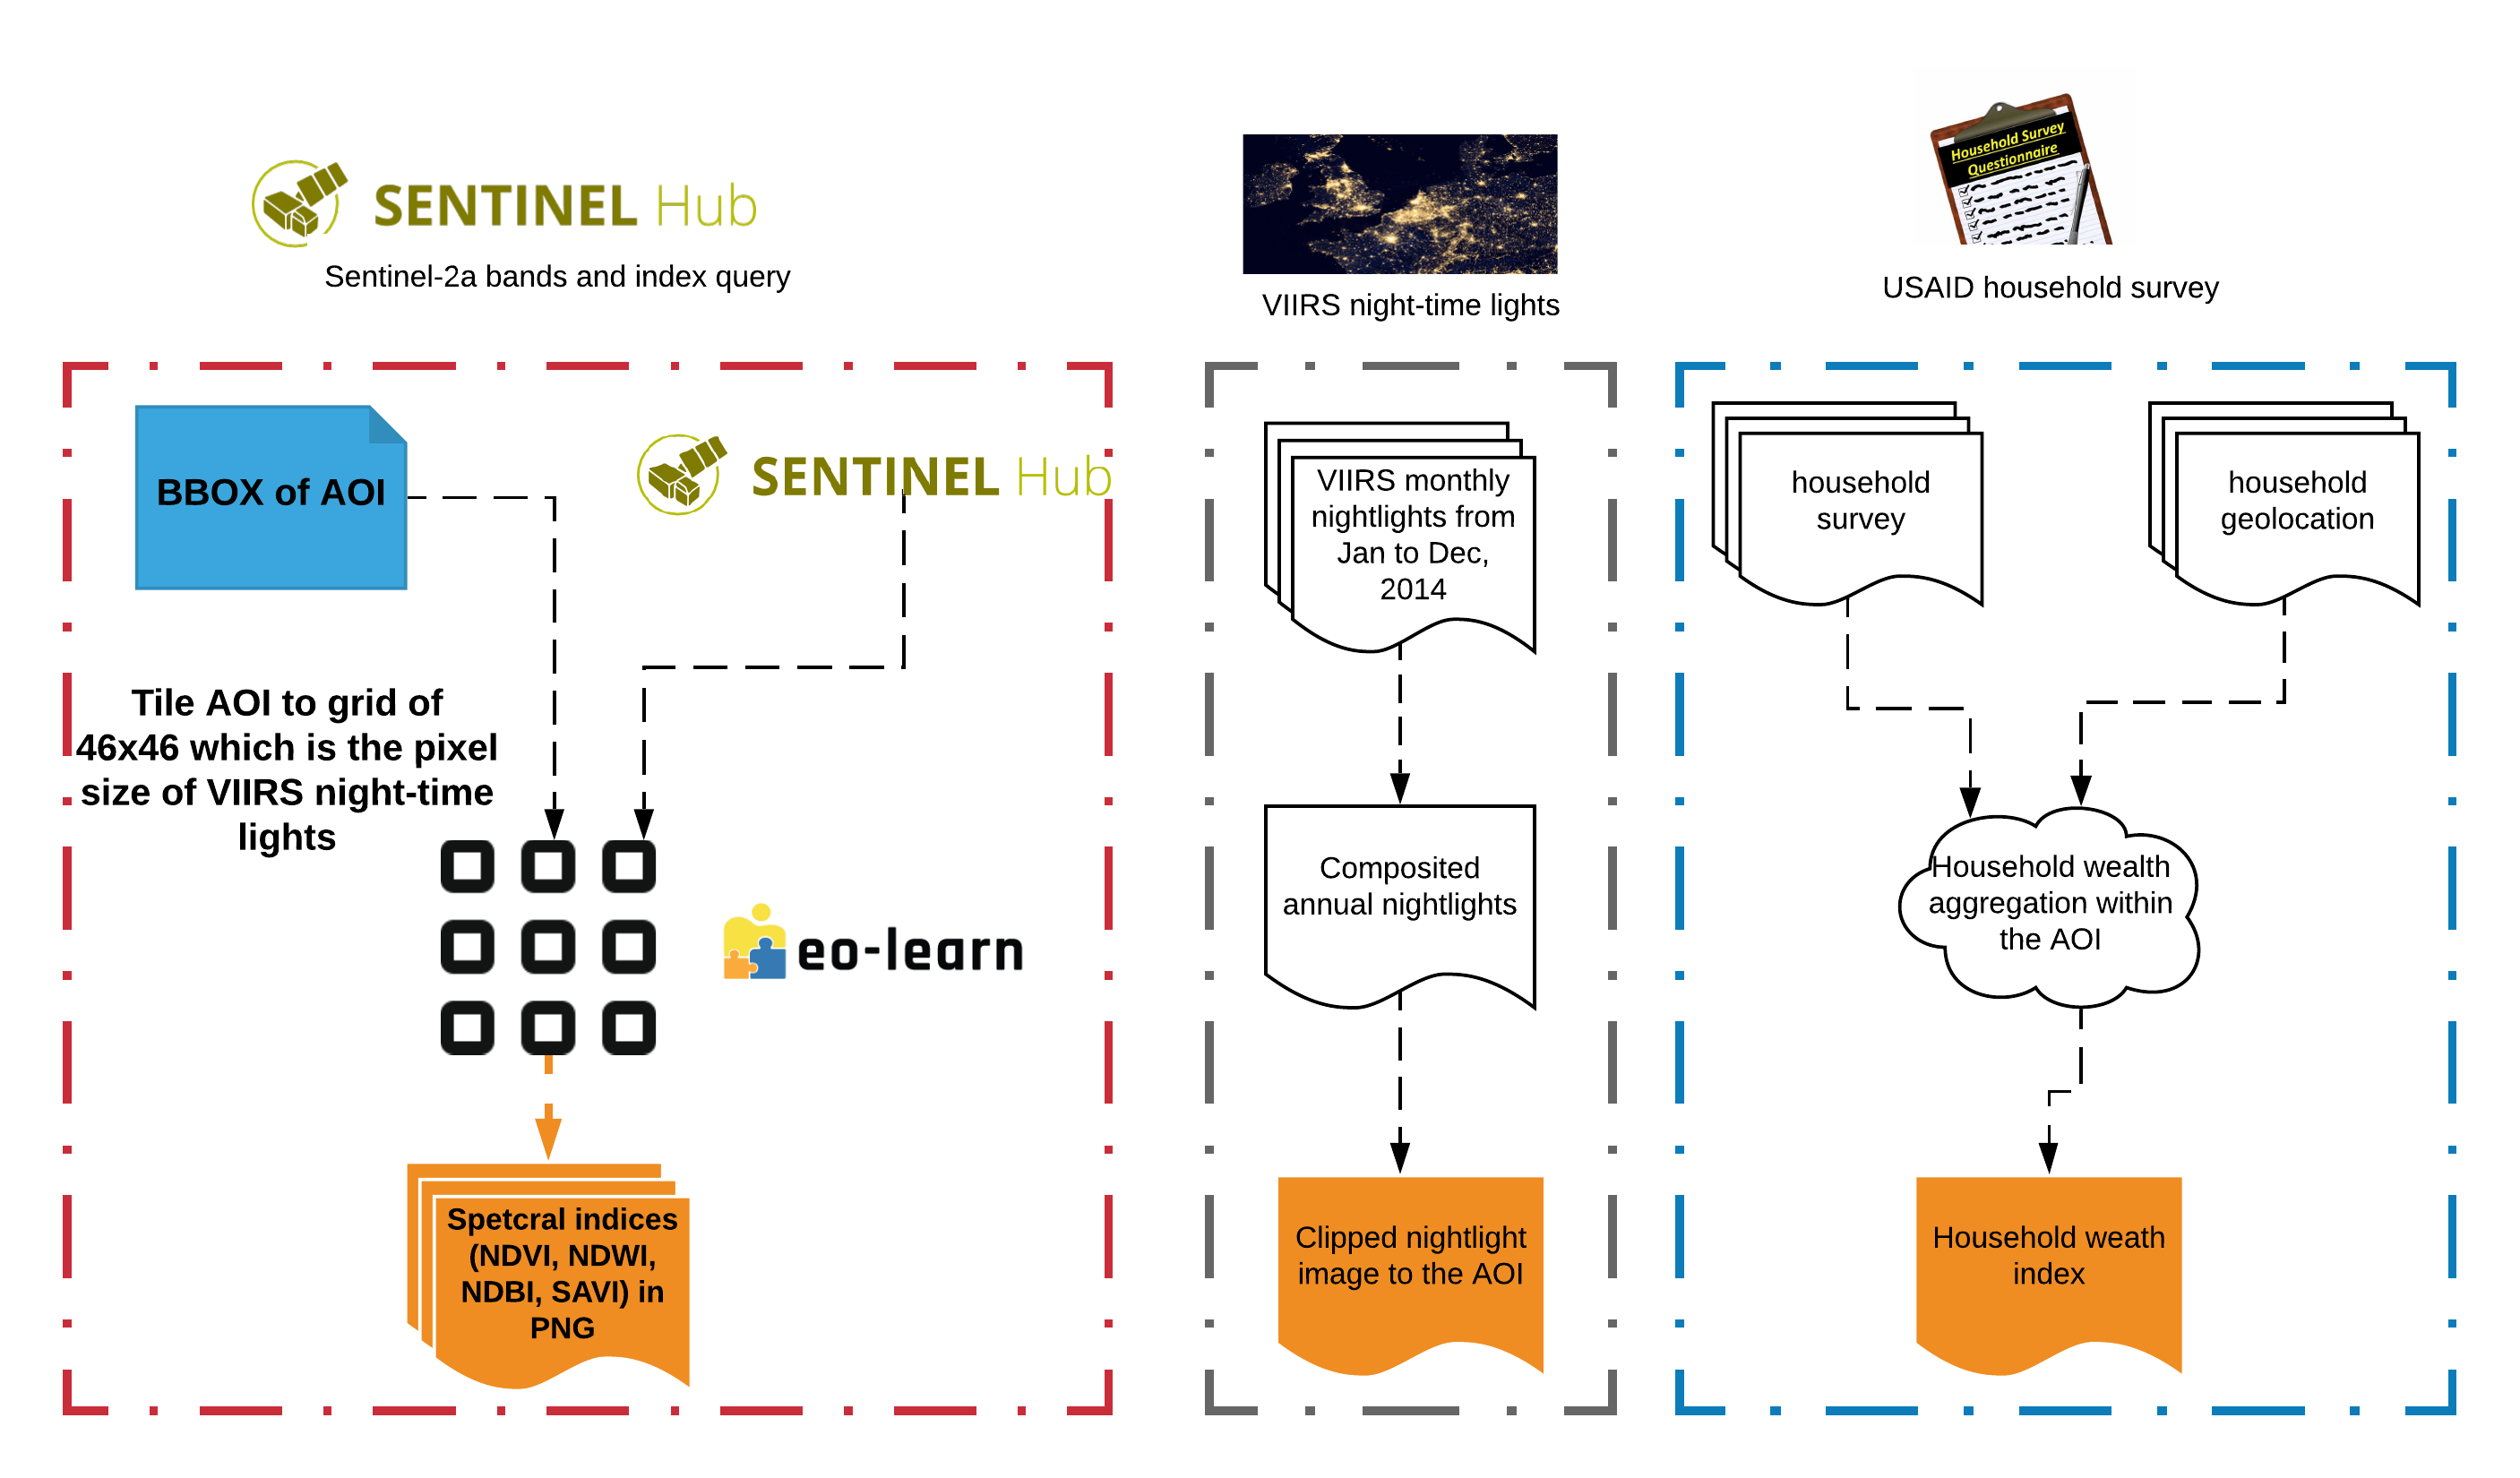

In [1]:
from IPython.display import Image
Image('figures/poverty_detection_data_sources.png')

### Data source 1: Sentinel-2 from SentinelHub. 

- NDVI - vegetation index- reflects the greenness of the neighborhood.
- NDWI - water index - wetness, running, and drinking water.
- NDBI - built-up index - humanmade built-up area and neighborhood pavement.
- SAVI - soil vegetation index, reflect neighborhood pavement, and greenness.

### Data source 2: VIIRS nightlight

VIIRS nighttime lights imagery that has been distributed since 2012 by The Earth Observations Group (EOG) at NOAA/NGDC, and is produced as monthly or annual averages. The data is available as mosaics that have been post-processed (i.e., to remove clouds, stray light, and lunar illumination).

### Data source 3: DHS household survey

The Demographic and Health Surveys (DHS) is a program that leads by USAID to collect, analyze, and disseminate accurate and representative data on population, health, HIV, and nutrition through over 90 countries. In this study, we are going to use DHS household survey and associated household GPS from Rwanda. Be mindful that you will need to request DHS datasets to the DHS program, and it may take a few days to get access to the data. 

## Areas of interest for the poverty detection in Rwanda

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, shutil, glob, random
from os import makedirs, path as op
from shutil import copyfile
from random import shuffle
from time import time
import json

import numpy as np
import numpy.ma as ma # for filling nan value with means
import geopandas as gpd

from sentinelhub import BBoxSplitter, CRS, CustomUrlParam

from eolearn.core import EOTask, FeatureType, SaveToDisk, AddFeature, OverwritePermission, LinearWorkflow, EOPatch, EOExecutor, LoadFromDisk
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask

# import utils script for pulling sentinel index instead of bands
from get_s2_sentinelhub import SentinelHubValidData, CountValid, NormalizedDifferenceIndex, SAVINorm, ConcatenateData, ValidDataFractionPredicate

# visualization
import matplotlib.pyplot as plt
from rasterio.plot import show
import seaborn as sns
import fiona


# image croping and creating geojson
import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling
import shapely
from shapely.geometry import mapping
from shapely.geometry import shape
from shapely.geometry import Polygon
from rasterio.windows import Window, bounds as wind_bounds
from rasterio.warp import transform_bounds



from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

#extract raster stats from nightlights
import rasterstats as rs
from PIL import Image
import pandas as pd


In [ ]:
country = "geopolygons/RWA_adm0.shp" # country boundary of Rwanda
train_aoi = "geopolygons/super_small_rwanda_aoi.geojson" #area of interest to train VGG16 later 
inference_aoi = "geopolygons/rwanda_test_aoi.geojson" #area of interest to test how a transfer learned model perform
t_crs = "EPSG:32736" # target projection for Rwanda
time_interval = ['2015-01-01', '2015-12-31'] # Sentinel-2a data available from 2015, but our DHS available from 2014

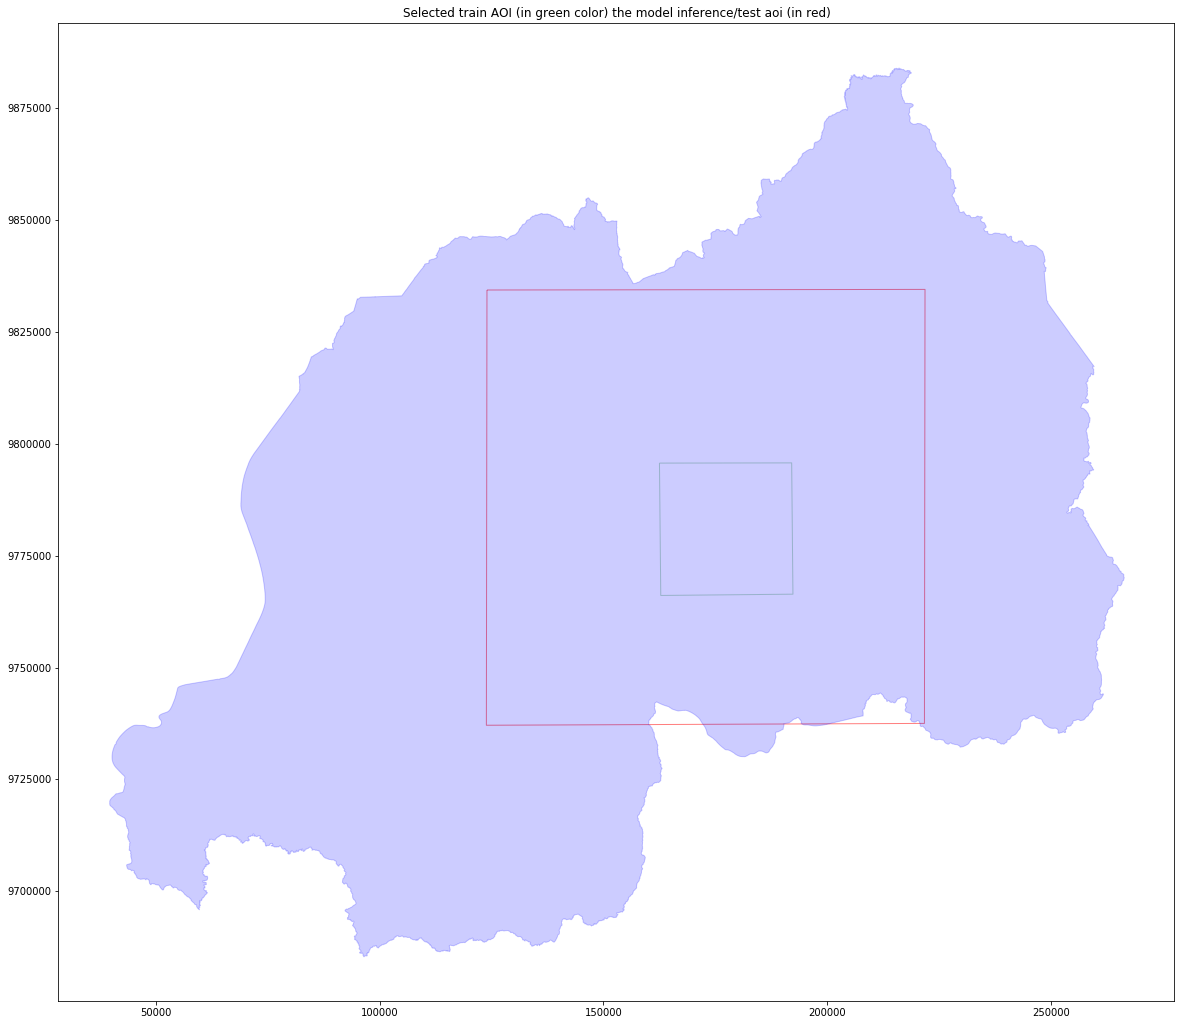

In [3]:
country_polyg = gpd.read_file(country)
train_polyg = gpd.read_file(train_aoi)
test_polyg = gpd.read_file(inference_aoi)

#reproject the polygons to the target projection
country_polyg = country_polyg.to_crs(crs={'init':t_crs})
train_polyg = train_polyg.to_crs(crs={'init': t_crs})
test_polyg = test_polyg.to_crs(crs =  {'init': t_crs})

fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 18}

fig, ax = plt.subplots(figsize=(20, 20))
train_polyg.plot(ax = ax, facecolor = 'w', edgecolor = 'g', alpha = 0.5) # training aoi in green
test_polyg.plot(ax = ax, facecolor = 'w', edgecolor = 'r', alpha = 0.5) # inference/test aoi in red
country_polyg.plot(ax =ax, facecolor='b', edgecolor='b', alpha = 0.2) # Rwanda
ax.set_title('Selected train AOI (in green color) the model inference/test aoi (in red)');

## SNPP VIIRS night-time light

In [ ]:
# we've composized monthly VIIRS nightlight to annual nightlight for a tile that cover Rwanda area
nl = "annual_00N060W_2014.tif" 
geo_fname = op.splitext(train_aoi.split("/")[-1])[0]
year =  2014
fout ='{}_{}.tif'.format(geo_fname, year)
with fiona.open(train_aoi, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

with rasterio.open(nl) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
    out_meta = src.meta.copy()
    out_image.astype(np.int8)
    
#output the clipped nightlights images for the training aoi
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(fout, "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
#reproject nightlights 
with rasterio.open(fout) as src:
    transform, width, height = calculate_default_transform(
            src.crs, t_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
            'crs': t_crs,
            'transform': transform,
            'width': width,
            'height': height
        })


    with rasterio.open('reproj_{}'.format(fout), 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=t_crs,
                resampling=Resampling.nearest)

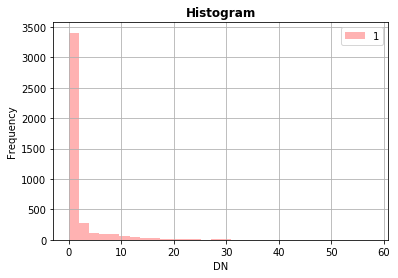

In [6]:
# visualize the nightlight intensity values
show_hist(out_image, bins=30, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

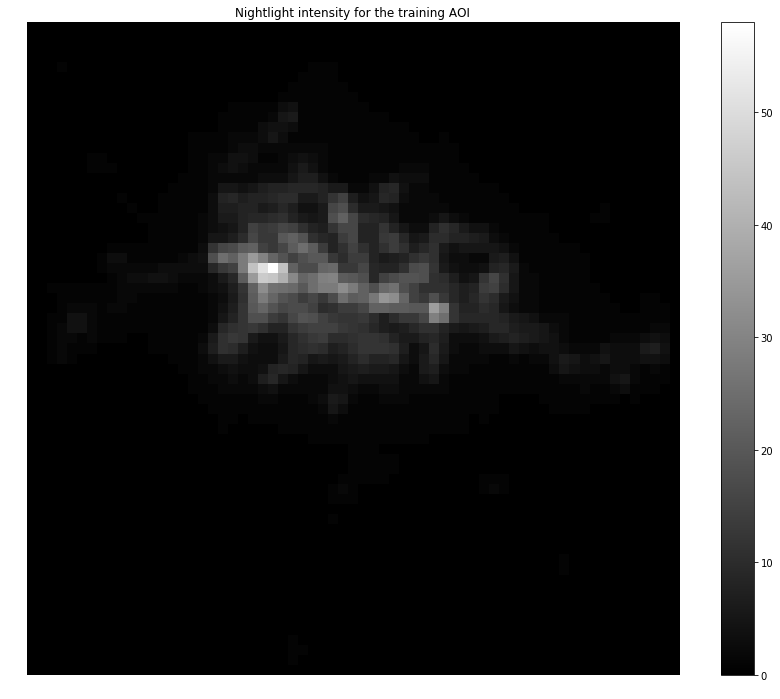

In [7]:
# nightlight intensity visualization, the training area is located around Rwanda's captial
nl_2014_train= rasterio.open("super_small_rwanda_aoi_2014.tif").read(1)
fig, ax = plt.subplots(figsize=(15,12))
ndvi = ax.imshow(nl_2014_train, cmap='gist_gray')
fig.colorbar(ndvi)
ax.set(title='Nightlight intensity for the training AOI')
ax.set_axis_off();

## DHS household wealth and VIIRS nightlight

### The coorelation between night-time lights intensity and household wealth

Household survey is hard and expensive to collect, but VIIRS nightlights has global coverage and in 462m resolution (pixel size). In the studay, we'll find the correlation between nightlight and household wealth that collected by DHS program. 

In [8]:
#data is pretty big and will take a while to read in
df_path = "RWHR70DT/RWHR70FL.DTA"

##if get utif8 erro using "rb" to read 
with open(df_path, "rb") as f:
    df = pd.read_stata(f)
df.head()

hhid hv000  hv001  hv002 hv003  hv004    hv005  hv006  hv007  \
0           1 1   RW6      1      1     1      1  1003964     11   2014   
1           1 2   RW6      1      2     1      1  1003964     11   2014   
2           1 3   RW6      1      3     1      1  1003964     11   2014   
3           1 4   RW6      1      4     1      1  1003964     11   2014   
4           1 5   RW6      1      5     1      1  1003964     11   2014   

   hv008   ...     hvc62_7  hvc62_8  hvc68_1  hvc68_2  hvc68_3  hvc68_4  \
0   1379   ...         NaN      NaN      NaN      NaN      NaN      NaN   
1   1379   ...         NaN      NaN      NaN      NaN      NaN      NaN   
2   1379   ...         NaN      NaN      NaN      NaN      NaN      NaN   
3   1379   ...         NaN      NaN      NaN      NaN      NaN      NaN   
4   1379   ...         NaN      NaN      NaN      NaN      NaN      NaN   

  hvc68_5  hvc68_6  hvc68_7  hvc68_8  
0     NaN      NaN      NaN      NaN  
1     NaN      NaN      NaN      NaN  
2     NaN      NaN      NaN      NaN  
3     NaN      NaN      NaN      NaN  
4     NaN      NaN      NaN      NaN  

[5 rows x 2712 columns]

In [9]:
wealth = df[['hv001','hv270','hv271']]
cluster_avg_asset = wealth.groupby('hv001')['hv271'].median().reset_index()
# There are 492 unique household survey in Rwanda
len(cluster_avg_asset)

492

In [10]:
# read in geolocations of household so we can map them 

gdf_RW = gpd.read_file("RWGE72FL/RWGE72FL.shp")
gps = gdf_RW[['DHSCLUST', 'URBAN_RURA', 'LATNUM', 'LONGNUM']] # only selected a few columns from the dataset
#join the household data with its geolocation information
result = cluster_avg_asset.merge(gps, how='inner', left_on='hv001', right_on='DHSCLUST')[['hv001', 'hv271','URBAN_RURA', 'LATNUM', 'LONGNUM']]
# assign wealth index to the household
result['wealth_Index'] = result['hv271']/10000
result.head()

hv001    hv271 URBAN_RURA    LATNUM    LONGNUM  wealth_Index
0      1  29967.0          R -2.505926  29.712786       2.99670
1      2 -44330.5          R -1.844667  30.310508      -4.43305
2      3 -46276.5          R -1.841935  29.574756      -4.62765
3      4 -54063.5          R -2.348161  30.463639      -5.40635
4      5 -20998.0          R -2.211301  30.161839      -2.09980

In [11]:
geo_result = gpd.GeoDataFrame(result, geometry=gpd.points_from_xy(result.LONGNUM, result.LATNUM))
geo_result.crs = {'init': 'epsg:4326'}
result_repro = geo_result.to_crs(crs={'init': t_crs})

In [12]:
ranks = [i for i in range(5)]
bins = [-80720, -36535, 0, 36246, 155870, 349092]
result_repro['rank'] = pd.cut(result_repro['hv271'], bins, labels=ranks)

The following map shows the household survey and wealth categories in Rwanda. The richer neiborhoods are located in urban areas. 

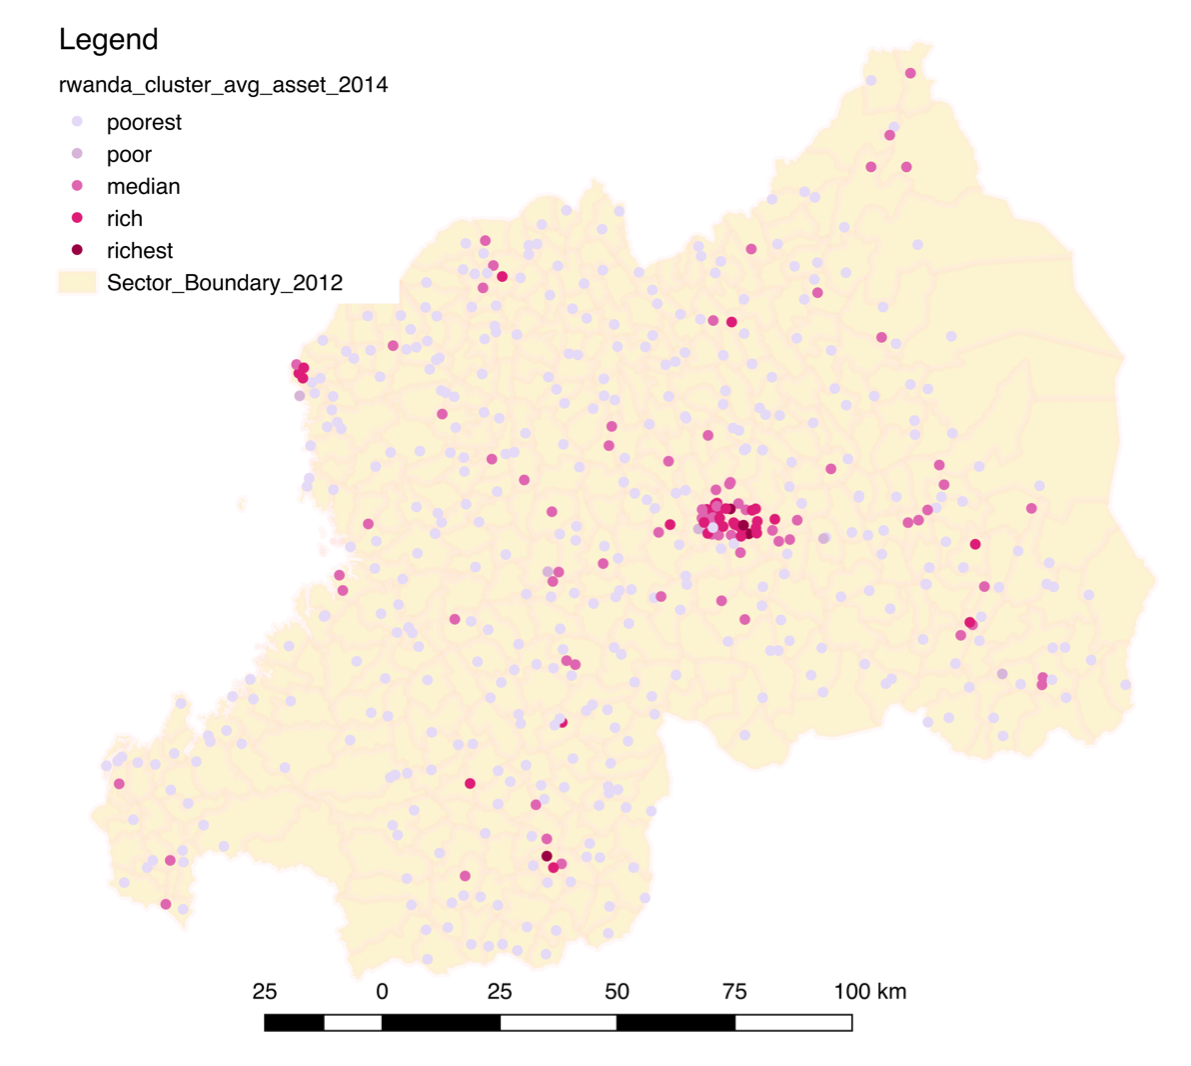

In [13]:
from IPython.display import Image
Image('figures/dhs_household_wealth.png')

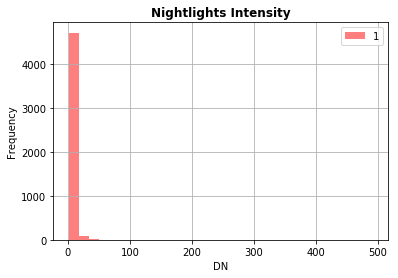

In [14]:
#read in the nightlight for the whole Rwanda to match the household survey data
nl_2014_raw = rasterio.open("reproj_RW_country_bbox_2014_country.tif")
nl_2014 = nl_2014_raw.read(1)
show_hist(nl_2014_raw, bins = 30, lw = 1, alpha = 0.5, title="Nightlights Intensity")

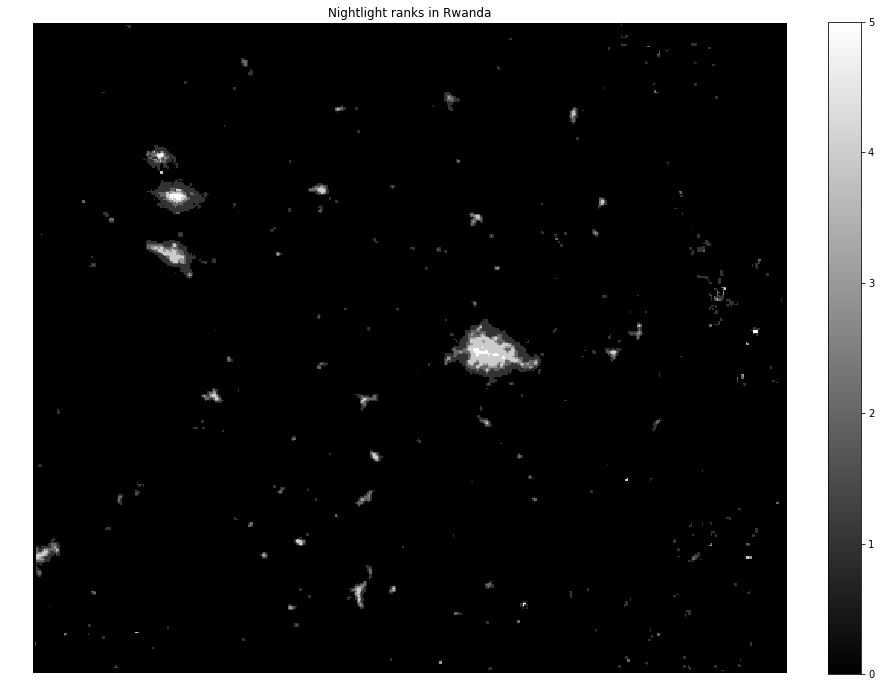

In [15]:
nl_bins = [0, 1, 3, 5,  22, 492]
new_nl = np.digitize(nl_2014, nl_bins, right=True)
# need to add a colorbar to this image
fig, ax = plt.subplots(figsize=(15,12))
nlv = ax.imshow(new_nl, cmap='gist_gray')
fig.colorbar(nlv, fraction=.05)
ax.set(title="Nightlight ranks in Rwanda")
ax.set_axis_off();

In [16]:
# Create a buffered polygon layer surved household location
result_repro_ = result_repro.copy()

# 1km buffered geometry
result_repro_["geometry"] = result_repro_.geometry.buffer(1000, cap_style=3)

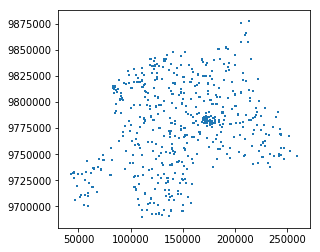

In [17]:
#let see the household buffer on the map
result_repro_.plot()

In [18]:
result_repro_.head()

hv001    hv271 URBAN_RURA    LATNUM    LONGNUM  wealth_Index  \
0      1  29967.0          R -2.505926  29.712786       2.99670   
1      2 -44330.5          R -1.844667  30.310508      -4.43305   
2      3 -46276.5          R -1.841935  29.574756      -4.62765   
3      4 -54063.5          R -2.348161  30.463639      -5.40635   
4      5 -20998.0          R -2.211301  30.161839      -2.09980   

                                            geometry rank  
0  POLYGON ((135361.6170911034 9723559.127360167,...    2  
1  POLYGON ((201770.512861348 9796881.967974382, ...    0  
2  POLYGON ((119823.5469346498 9797043.583046347,...    0  
3  POLYGON ((218909.4705193237 9741200.25277034, ...    0  
4  POLYGON ((185287.7247788421 9756281.679810084,...    1

In [19]:
result_repro_ = result_repro_[['hv001', 'hv271','rank', 'geometry']]
affine = nl_2014_raw.transform

In [20]:
dhs_nl = rs.zonal_stats(gpd.GeoDataFrame(result_repro_),
                        new_nl,
                        affine= affine,
                        geojson_out=True,
                        copy_properties=True,
                        stats=["mean", 'std'])

In [21]:
dhs_nl_new = rs.zonal_stats(gpd.GeoDataFrame(result_repro_),
                        new_nl,
                        affine= affine,
                        geojson_out=True,
                        copy_properties=True,
                        stats=["median"])

In [22]:
# create a geo-dataframe for nightlight and household wealth so we can run some regression to find some correlation
geometry = [shape(feat["geometry"]) for feat in dhs_nl]
props = [feat["properties"] for feat in dhs_nl]
result = gpd.GeoDataFrame(props, crs={'init': t_crs}, geometry=geometry)
result['wealth_idx'] = result['hv271']/100000

In [23]:
result.head()

hv001    hv271  mean  rank  std  \
0      1  29967.0   0.0   2.0  0.0   
1      2 -44330.5   0.0   0.0  0.0   
2      3 -46276.5   0.0   0.0  0.0   
3      4 -54063.5   0.0   0.0  0.0   
4      5 -20998.0   0.0   1.0  0.0   

                                            geometry  wealth_idx  
0  POLYGON ((135361.6170911034 9723559.127360167,...    0.299670  
1  POLYGON ((201770.512861348 9796881.967974382, ...   -0.443305  
2  POLYGON ((119823.5469346498 9797043.583046347,...   -0.462765  
3  POLYGON ((218909.4705193237 9741200.25277034, ...   -0.540635  
4  POLYGON ((185287.7247788421 9756281.679810084,...   -0.209980

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 5)

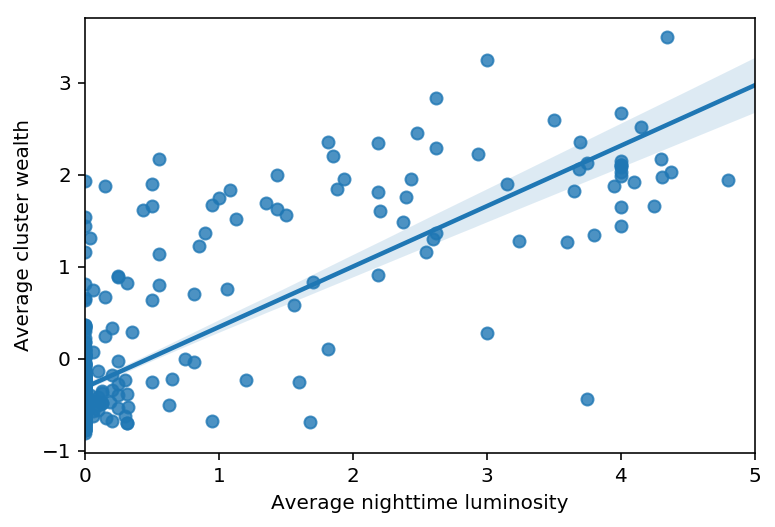

In [24]:
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="mean", y="wealth_idx", data=result)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.xlim([0, round(max(result['mean']))])

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

# reproj_ = reproj.reset_index()
reproj = clean_dataset(result[['mean', 'std', 'rank']])

# data_all = pd.read_csv('intermediate_files/DHS_nightlights.csv')
df_stats = reproj[['mean','std', 'rank']].as_matrix()

In [ ]:
np.random.seed(123)
# from sklearn.ensemble import RandomForestRegressor

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(df_stats):
        clf = LogisticRegression()
        train = df_stats[train_index]
        test = df_stats[test_index]
        clf.fit(train[:, :-1], train[:, -1])
        s = clf.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

In [46]:
print('R^2 of the best model: {:.3f}'.format(np.max(final)))

R^2 of the best model: 0.615


## Fetch Sentinel-2a spectral indexes from SentinelHub using `eo-learn`

The following workflow works you through how to download Sentinel-2A bands from SentinelHub with `eo-learn`, and burn  PNG images that will be used to train a neural net for poverty detection. It was divided into the following few steps:
- Create an image grid based on nightlight's image's pixels and pixel size. The grid is 460m x 460m, the pixel size of the nightlight image. 
- Extract bands and creates indexes, e.g. NDVI, NDWI, NDBI, and SAVI at EOPatches; 
- Created a numpy array of smoothed/averaged time-series Sentinel-2 indexes, and add the nightlight value to the EOPatch. 
- Burn a PNG  from the averaged numpy array. NDVI, NDWI, and NDBI were burned as RGB. 
- We grouped PNGs based on the associated nightlight values for the coming deep learning classification. For instance,  all the indexes PNGs that have associated nightlight value between 0 to 1 were grouped as "no_light" which also associate with the poorest class in poverty detection from above logistic regression. We put PGNs have nightlight values between 1-2 to "low_light" group, PNGs that are under nightlight values of 2 - 9 were grouped as "med_light" and under nightlight value of 9-18 were grouped as "med_high_light" and PNGs that has nightlight value above 18 were labeled as "high_light". 


The following PNG (southern part of Kigali, Rwanda) is what the neural net is seeing when we used NDVI, NDWI and NDBI burn as RGB, instead of using Red, Green and Blue bands. Manmade area stands out as blue, water as green and vegetation as red. 

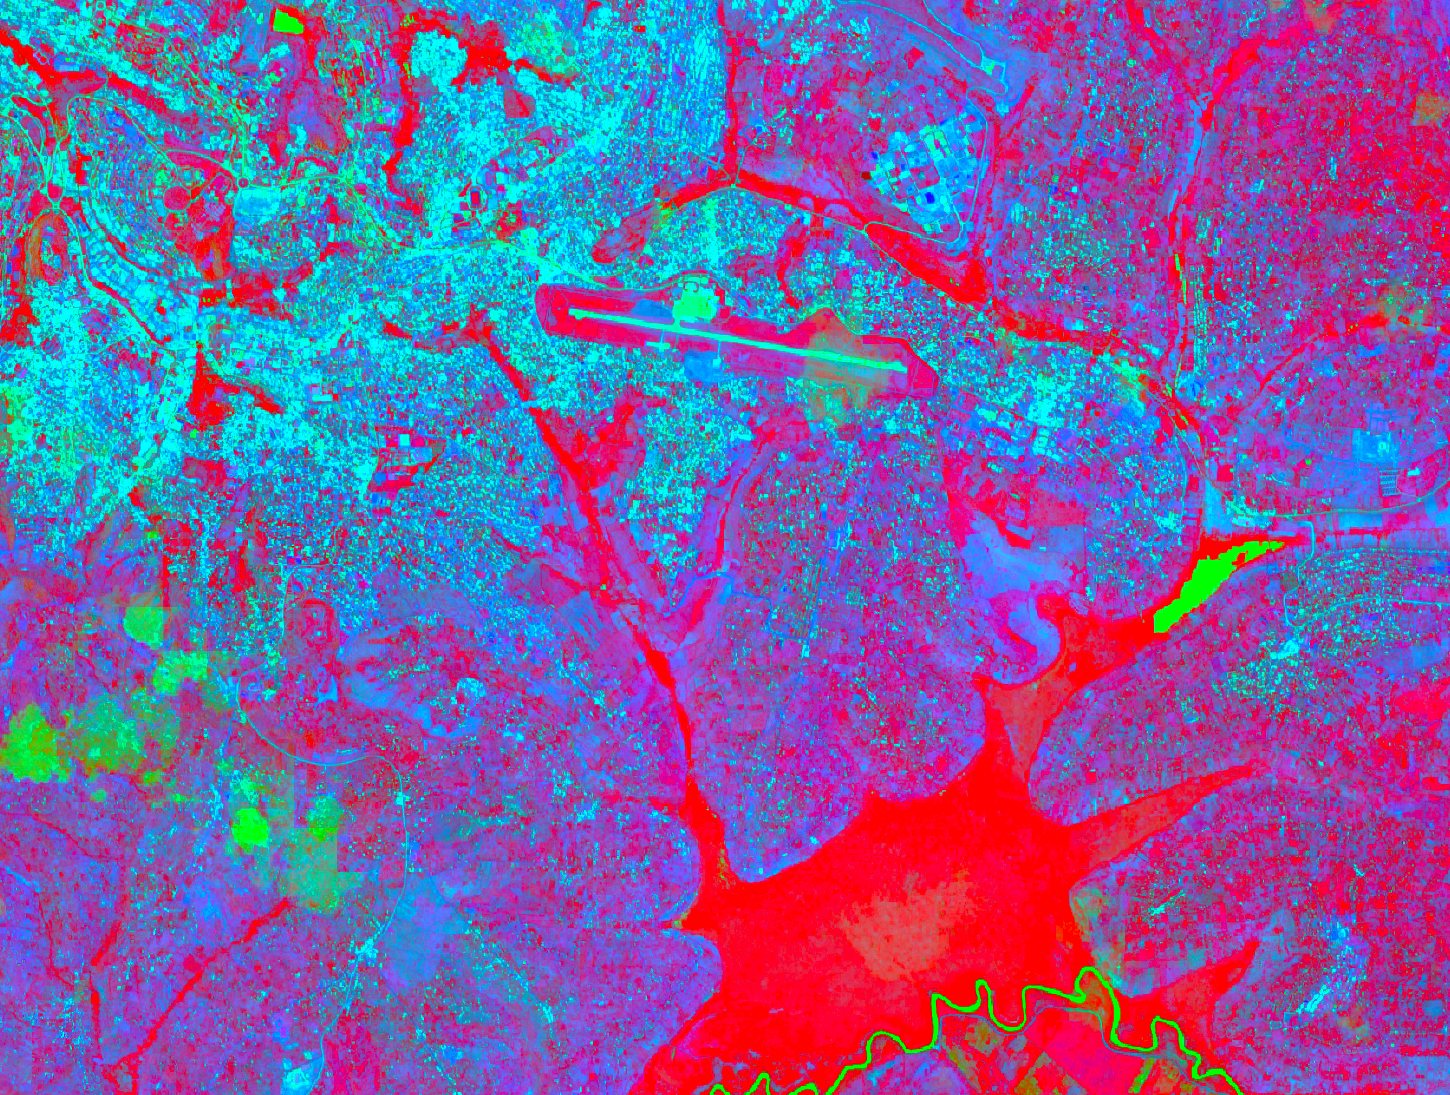

In [1]:
from IPython.display import Image
Image('figures/indexes_rbg.png')

In [26]:
def create_grids(nl_lights, t_crs, grid_sz = 46):
    """
    Loop through nightlight pixels in the geotif to create grid cells. 
    
    ---
    Param
    
    nl_lights: geotif of nightlight of the training area;
    t_crs: target CRS for the grid cell
    grid_sz: grid cell size.
    
    Return
    patchIDs: patch ID to collect sentinel-2 imagery from SentinelHub
    tile_list: EOpatch that contain boundbox of grid cell to fetch Sentinel-2 spectral information
    
    """
    gpd_geo=list()
    prop = list()
    patchIDs = list()
    tile_lists = list()
    # loop through each row and column of nightlight pixel to creat bounding box
    with rasterio.open(nl_lights) as src_dst:
        for col_off in range(0, src_dst.width):
            for row_off in range(0, src_dst.height):
                bounds = wind_bounds(Window(col_off, row_off, 1, 1), src_dst.transform)
                xmin, ymin, xmax, ymax = transform_bounds(
                    *[src_dst.crs, "epsg:4326"] + list(bounds), densify_pts=21
                )
                poly = shapely.geometry.Polygon([
                    (xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)
                ])
                gpd_geo.append(poly)
                prop.append("{}_{}".format(col_off, row_off))
    gpd_df = gpd.GeoDataFrame(prop, crs = {'init': 'epsg:4326'}, geometry=gpd_geo)
    gpd_reproj= gpd_df.to_crs(crs={'init': 'epsg:4326'})
    gpd_reproj = gpd_reproj.rename(columns={0: "id", "geometry": "geometry"})
    gpd_reproj = gpd_reproj.to_crs(crs={'init': t_crs})
    designed_bbox_shapes = gpd_reproj.geometry.values.tolist()
    for aoi_shape in designed_bbox_shapes:
        width_pix = int((aoi_shape.bounds[2] - aoi_shape.bounds[0])/10)
        heigth_pix = int((aoi_shape.bounds[3] - aoi_shape.bounds[1])/10)
        print('Dimension of the area is {} x {} pixels'.format(width_pix, heigth_pix))
        width_grid = int(round(width_pix/grid_sz))
        heigth_grid =  int(round(heigth_pix/grid_sz))

        # split the tile grid by the desired grid number
        tile_splitter = BBoxSplitter([aoi_shape], t_crs, (width_grid, heigth_grid))
        print("The area is splitted into a grid with {} by {} tiles!".format(width_grid, heigth_grid))

        tile_list = np.array(tile_splitter.get_bbox_list())
        info_list = np.array(tile_splitter.get_info_list())

        # get the all pylogon information from the splitted AOI
        idxs_x = [info['index_x'] for info in tile_splitter.info_list]
        idxs_y = [info['index_y'] for info in tile_splitter.info_list]
        tile_lists.append(tile_list)

        #save all the patch ID for tiles and save it as numpy array
        for idx, [bbox, info] in enumerate(zip(tile_list, info_list)):
            patchIDs.append(idx)
    patchIDs = np.array([i for i in range(len(patchIDs))])
    tile_list = np.array(tile_lists).flatten()
    return patchIDs, tile_list

In [ ]:
# we knew that VIIRS pixel size is 462m.
# with 10m resolution of Sentinel-2, 46 by 46 pixel will cover a pixel of nightlight
patchIDs, tile_list = create_grids(fout, t_crs)

In [49]:
class ConcatenateNL(EOTask):
    """Task to concatenate data arrays along the last dimension"""
    def __init__(self, feat_name, nl_label, ids_label, nl_tif,):
        self.feat_name = feat_name
        self.nl_label = nl_label 
        self.ids_label = ids_label
        self.nl_tif = nl_tif

    def execute(self, eopatch):
        bbox = eopatch.bbox
        bbox_geo= [{'type': 'Polygon', 'coordinates': [bbox.get_polygon()]}]
        features = eopatch.data[self.feat_name]
        inds_full = list()    
        for i in range(len(features)):
            inds = features[i][...,[0, 1, 2]]
            if inds.max() >0:
                inds_full.append(inds)
        inds_arr = np.array(inds_full)
        inds_means = inds_arr.mean(axis = (0))
        with rasterio.open(self.nl_tif) as nl:
            nl_arr, outtransform = rasterio.mask.mask(nl, bbox_geo, crop=True)
            nl_arr = np.moveaxis(nl_arr, 0, -1)
            nl_max = nl_arr.max()
            nl_new = np.zeros((46, 46, 1))
            nl_new = np.full(nl_new.shape, nl_max).astype("float")
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.nl_label, nl_new)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.ids_label, inds_means)

        return eopatch

In [50]:
# fetch the Eopatch IDs along with tiles list from the input AOI for training

print("Extracting the dataset from SentinelHub with eo-learning:")
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.99, # maximum allowed cloud cover of original ESA tiles
)
#[B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2]

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# SAVI: (B08 - B04)/(B08 + B04 + 0.5) * (1+0.5)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
ndbi = NormalizedDifferenceIndex('NDBI', 'BANDS/4', 'BANDS/3')
savi = SAVINorm('SAVI', 'BANDS/3', 'BANDS/2')
# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['NDVI', 'NDWI', 'NDBI', 'SAVI'])
# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 99 % valid coverage
valid_pixels = 0.99
valid_data_predicate = ValidDataFractionPredicate(valid_pixels)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling every month
resampling = 30
resampled_range = (time_interval[0], time_interval[1], resampling)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)
add_nl = ConcatenateNL('FEATURES', 'nightlights', 'inds_data', 'reproj_{}'.format(fout))
path_out_sampled =  op.splitext(train_aoi.split("/")[-1])[0]
if not op.isdir(path_out_sampled):
    makedirs(path_out_sampled)
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
workflow = LinearWorkflow(
        add_data,
        add_clm,
        ndvi,
        ndwi,
        ndbi,
        savi,
        add_sh_valmask,
        count_val_sh,
        concatenate,
        filter_task,
        linear_interp,
        add_nl,
        save)

Extracting the dataset from SentinelHub with eo-learning:


In [51]:
execution_args = []
for idx, bbox in enumerate(tile_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()

In [52]:
pathch = 10
EOPatch.load("../super_small_test/eopatch_{}/".format(pathch))

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(13, 46, 46, 4), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    inds_data: numpy.ndarray(shape=(46, 46, 3), dtype=float64)
    nightlights: numpy.ndarray(shape=(46, 46, 1), dtype=float64)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((162248.43331084395, 9790881.618910803), (162712.60498074128, 9791345.790580705)), crs=EPSG:32736)
  timestamp: [datetime.datetime(2015, 1, 1, 0, 0), ..., datetime.datetime(2015, 12, 27, 0, 0)], length=13
)

In [20]:
def color_scale(arr):
    """correct the RGB bands to be a composed bands of value between 0 255 for visualization purpos
    
    Args:
        arr: RGB bands in numpy array 
    Return:
        arr: numpy array that values range from 0 to 255 for visualization
    """
    str_arr = (arr + 1) * 127.5
    return str_arr

def burn_png(pathID):
    patData = EOPatch.load(pathID)
    patch_id = pathID.split("/")[-1]
    nl_mat = patData.data_timeless['nightlights']
    ind_mat = patData.data_timeless['inds_data']

    inds = color_scale(ind_mat).astype("uint8")
    nl_val = int(nl_mat.max())
    train_dir = "trainingData/{}".format(nl_val)
    if not op.isdir(train_dir):
        makedirs(train_dir)
    Image.fromarray(inds).save(op.join(train_dir, "{}.png".format(patch_id)))

In [61]:
def png2group(min_val, max_val, group):
    new_train_path = "categorize_train_s2/{}/".format(group)
    if not op.isdir(new_train_path):
        makedirs(new_train_path)
    for i in range(min_val, max_val):
        path = "trainingData/{}/".format(str(i))
        for f in os.listdir(path):
            copyfile(path+f, new_train_path+f)
            print("copied {} from {} to {}".format(f, path+f, new_train_path+f))

In [63]:
patches  = sorted(glob.glob("../super_small_test/*"))
from PIL import Image
for patch in patches: burn_png(patch)

In [ ]:
png2group(0,1,'no_light')
png2group(1,2,'low_light')
png2group(2,9,'med_light')
png2group(9,18,'med_high_light')
png2group(18,58,'high_light')

In [28]:
def split_train(train_dir, keyword, img_format = None):

    """
    script to split train and test dataset for image classification by 80:20

    :param train_dir: path to rgb training dataset
    :param keyword: catagory name as the keyword
    :param img_format: the image format that produced from tile serve

    :return None: split train and validation in seperate directories with the keywords as the sub-directories.
    """

    train_path = "train"
    val_path = "validation"
    test_path = "test"
    if not op.isdir(train_path):
        makedirs(train_path)
    if not op.isdir(val_path):
        makedirs(val_path)
    if not op.isdir(test_path):
        makedirs(test_path)
    img_train_path = op.join(train_path, keyword)
    if not op.isdir(img_train_path):
        makedirs(img_train_path)
    img_val_path = op.join(val_path, keyword)
    if not op.isdir(img_val_path):
        makedirs(img_val_path)
    img_test_path = op.join(test_path, keyword)
    if not op.isdir(img_test_path):
        makedirs(img_test_path)
    images = sorted(glob.glob(train_dir + "/*." + img_format))
    random.seed(230)
    shuffle(images)
    print(len(images))
    split_train = int(0.7 * len(images))
    split_valid = int(0.9 * len(images))
    # split_test = int(len(images)-split_valid)
    print("total training, validationg and test dataset are")
    train_files = images[:split_train]
    val_files = images[split_train:split_valid]
    test_files = images[split_valid:]
    print("{}, {} and {}".format(len(train_files),len(val_files) ,len(test_files)))
    for img in train_files:
        shutil.copy(img, img_train_path)
    for img_v in val_files:
        shutil.copy(img_v, img_val_path)
    for img_t in test_files:
        shutil.copy(img_t, img_test_path)

In [29]:
split_train("categorize_train_s2/no_light", "poorest", img_format = "png")

2803
total training, validationg and test dataset are
1962, 560 and 281


In [30]:
split_train("categorize_train_s2/low_light", "poor", img_format = "png")

767
total training, validationg and test dataset are
536, 154 and 77


In [31]:
split_train("categorize_train_s2/med_light", "average", img_format = "png")

575
total training, validationg and test dataset are
402, 115 and 58


In [32]:
split_train("categorize_train_s2/med_high_light", "rich", img_format = "png")

233
total training, validationg and test dataset are
163, 46 and 24


In [33]:
split_train("categorize_train_s2/high_light", "richest", img_format = "png")

81
total training, validationg and test dataset are
56, 16 and 9


## Train VGG16

The following model was run on AWS Deep Learning AMI P2.xlarge machine. 

In [1]:
import os
from os import path as op
from functools import partial
import numpy as np
from utils import (print_start_details, print_end_details)
from datetime import datetime as dt
from train_config_pd import (tboard_dir, ckpt_dir, data_dir,
                    model_params as MP, train_params as TP, data_flow as DF)
from hyperopt import fmin, Trials, STATUS_OK, tpe
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input as xcept_preproc
from Vgg16 import vgg16_net
from mobilenetv2 import mobilenet_v2
from hyperopt import hp
import pickle
from datetime import datetime as dt


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np

In [2]:
def get_params(MP, TP):
    """Return hyperopt parameters"""
    return dict(
        optimizer=hp.choice('optimizer', MP['optimizer']),
        lr_phase1=hp.uniform('lr_phase1', MP['lr_phase1'][0], MP['lr_phase1'][1]),
        lr_phase2=hp.uniform('lr_phase2', MP['lr_phase2'][0], MP['lr_phase2'][1]),
        weight_init=hp.choice('weight_init', MP['weight_init']),
        freeze_cutoff=hp.choice('freeze_cutoff', MP['freeze_cutoff']),
        dropout_rate=hp.choice('dropout_rate', MP['dropout_rate']),
        dense_size=hp.choice('dense_size', MP['dense_size']),
        dense_activation=hp.choice('dense_activation', MP['dense_activation']),
        n_epo_phase1=hp.quniform('n_epo_phase1', TP['n_epo_phase1'][0], TP['n_epo_phase1'][1], 1),
        n_epo_phase2=TP['n_epo_phase2'],
        n_classes=MP['n_classes'],
        output_activation=hp.choice('output_activation', MP['output_activation']),
        loss=hp.choice('loss', MP['loss']),
        steps_per_train_epo=TP['steps_per_train_epo'],
        steps_per_test_epo=TP['steps_per_test_epo'],
        max_queue_size=TP['max_queue_size'],
        workers=TP['workers'],
        use_multiprocessing=TP['use_multiprocessing'],
        class_weight=TP['class_weight'])

def train(train_dir, validation_dir, model_id):
    start_time = dt.now()
    print_start_details(start_time)


    ###################################
    # Calculate number of train/test images
    ###################################
    total_test_images = 0
    # Print out how many images are available for train/test
    for fold in [train_dir, validation_dir]:
        for sub_fold in ['average', 'poor', 'poorest', 'rich', 'richest']:
            temp_img_dir = op.join(data_dir, fold, sub_fold)
            n_fnames = len([fname for fname in os.listdir(temp_img_dir)
                            if op.splitext(fname)[-1] in ['.png']])
            print('For {}ing, found {} {} images'.format(fold, n_fnames, sub_fold))

            if fold == validation_dir:
                total_test_images += n_fnames
    if TP['steps_per_test_epo'] is None:
        TP['steps_per_test_epo'] = np.ceil(total_test_images / DF['flow_from_dir']['batch_size']) + 1

    ###################################
    # Set up generators
    ###################################

    if model_id=="vgg16_net":
        model = vgg16_net
    else:
        model = mobilenet_v2

    trials = Trials()
    algo = partial(tpe.suggest, n_startup_jobs=5)
    argmin = fmin(model, space=get_params(MP, TP), algo=algo,
                  max_evals=100, trials=trials)

    end_time = dt.now()
    print_end_details(start_time, end_time)
    print("Evalutation of best performing model:")
    print(trials.best_trial['result']['loss'])

    with open(op.join(ckpt_dir, 'trials_{}.pkl'.format(start_time)), "wb") as pkl_file:
        pickle.dump(trials, pkl_file)


In [ ]:
train_dir = "train"
validation_dir = "validation"
model_id = "vgg16_net"
train(train_dir, validation_dir, model_id)

## Run prediction from above trained model

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import keras.backend as K
from keras.utils import multi_gpu_model
from keras.applications.xception import preprocess_input as xcept_preproc
from keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preproc
from PIL import Image
import yaml
from os import makedirs, path as op
import glob
from datetime import datetime as dt
# from focal_losses import categorical_focal_loss_fixed

In [3]:
from pred_cong_pd import ckpt_dir, preds_dir, pred_params as pred_p
from utils import load_model

In [15]:
def burn_png_pred(pathID):
    patData = EOPatch.load(pathID)
    patch_id = pathID.split("/")[-1]
    nl_mat = patData.data_timeless['nightlights']
    ind_mat = patData.data_timeless['inds_data']

    inds = color_scale(ind_mat).astype("uint8")
#     pred_dir = "prediction"
    if not op.isdir(pred_dir):
        makedirs(pred_dir)
    Image.fromarray(inds).save(op.join(pred_dir, "{}.png".format(patch_id)))

In [13]:
eopatches = os.listdir("rwanda_test_aoi")

In [17]:
pred_dir = "prediction_test_aoi_png"
if not op.isdir(pred_dir):
    makedirs(pred_dir)

In [4]:
EOPatch.load("rwanda_test_aoi/eopatch_0/")

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(13, 46, 46, 4), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    inds_data: numpy.ndarray(shape=(46, 46, 3), dtype=float64)
    nightlights: numpy.ndarray(shape=(46, 46, 1), dtype=float64)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((123194.02301421028, 9834273.985315358), (123658.03201200388, 9834737.994313158)), crs=EPSG:32736)
  timestamp: [datetime.datetime(2015, 1, 1, 0, 0), ..., datetime.datetime(2015, 12, 27, 0, 0)], length=13
)

In [34]:
patches  = sorted(glob.glob("rwanda_test_aoi/*"))
from PIL import Image
for patch in patches: burn_png_pred(patch)

In [4]:
def customize_pred(pred):
    max_i = np.argmax(pred)
    i_ele = np.array(['average', 'poor', 'poorest', 'rich', 'richest'])

    return i_ele[max_i]

In [5]:
def predict(png_dir, eopath_dir, outfile = "rw_test_aoi_5cls.json"):
    if pred_p['n_gpus'] > 1:
        # Load weights on CPU to avoid taking up GPU space
        with tf.device('/cpu:0'):
            template_model = load_model(op.join(ckpt_dir, pred_p['model_arch_fname']),
                                        op.join(ckpt_dir, pred_p['model_weights_fname']))
        parallel_model = multi_gpu_model(template_model, gpus=pred_p['n_gpus'])
    else:
        template_model = load_model(op.join(ckpt_dir, pred_p['model_arch_fname']),
                                    op.join(ckpt_dir, pred_p['model_weights_fname']))
        parallel_model = template_model

    # Turn of training. This is supposed to be faster (haven't seen this empirically though)
    K.set_learning_phase = 0
    for layer in template_model.layers:
        layer.trainable = False

    parallel_batch_size = pred_p['single_batch_size'] * pred_p['n_gpus']

    # Load model parameters for printing
    with open(op.join(ckpt_dir, pred_p['model_params_fname']), 'r') as f_model_params:
        params_yaml = f_model_params.read()
        model_params = yaml.load(params_yaml)
    print('\n' + "=" * 40)
    print('Loaded model: {}\n\twith params: {}, gpus: {}'.format(
        pred_p['model_arch_fname'], pred_p['model_weights_fname'], pred_p['n_gpus']))


    ####################################################
    # Create filenames to process, exclude existing ones
    ####################################################

    all_tile_fnames = os.listdir(png_dir)
    all_tile_inds = [op.splitext(tile)[0] for tile in all_tile_fnames]


    print('\n{} tiles to predict on'.format(len(all_tile_inds)))

    print('{} tiles to predict on after set exclusion and file check'.format(len(all_tile_inds)))

    ###############################
    # Predict on batches of images
    ###############################
    n_batches = -1
    n_images_processed = 0
    y_preds = []
    pred_dict = dict()

    st_dt = dt.now()
    start_time = st_dt.strftime("%m%d_%H%M%S")
    print('Start time: {}'.format(start_time))

    batch_size = pred_p['single_batch_size'] * pred_p['n_gpus']
    n_batches = len(all_tile_inds) // batch_size

    for bi in range(n_batches - 1):
        batch_st = dt.now()

        ########################################
        # Load batch into memory
        ########################################
        batch_inds = all_tile_inds[bi * batch_size:(bi + 1) * batch_size]
        batch_fpaths = [op.join(png_dir, ind + '.png') for ind in batch_inds]
        img_batch = np.empty((len(batch_inds), 46, 46, 3))
        for ii, image_fpath in enumerate(batch_fpaths):
            try:
                img_batch[ii] = np.array(Image.open(image_fpath))
            except OSError as os_err:
                print("Error loading {}, subbing zeros for image".format(image_fpath))
                img_batch[ii] = np.zeros((46, 46, 3))


        ########################################
        # Preproc and predict on batch of images
        ########################################
        image_tensor = vgg16_preproc(img_batch)


        y_p = parallel_model.predict(image_tensor, batch_size=parallel_batch_size,
                                     verbose=0)

        ########################################
        # Save batch into json dict
        ########################################
        # Get only prob of positive example and round
        temp_preds = np.around(y_p[:, :], decimals=2)
        print("the original prediction {}".format(y_p))
        print("new round up prediction is {}".format(temp_preds))
        print("**"*30)

        y_preds.extend(temp_preds)
        for d_key, d_pred in zip(batch_inds, temp_preds):
            patch_data  = EOPatch.load("{}/eopatch_{}/".format(eopath_dir, d_key))
            bbox = patch_data.bbox
            bbox_geo= {'type': 'Polygon', 'coordinates': [bbox.get_polygon()]}
            pred_dict[d_key] = [str(d_pred), customize_pred(d_pred), bbox_geo]

        n_images_processed += len(y_p)

        batch_delta = dt.now() - batch_st
        print('Batch {}/{}; elapsed time: {}, {} per image'.format(
            bi, n_batches - 2, batch_delta, batch_delta / len(y_p)))
        # Every once in a while, save predictions
        if bi % 200 == 0 or bi == n_batches - 2:
            with open(outfile, 'w') as new_pred_f:
                json.dump(pred_dict, new_pred_f)
            print('Last key: {}'.format(batch_inds[-1]))


    delta = dt.now() - st_dt
    print('Elapsed time: %s, %s per image' % (delta, delta / n_images_processed))


In [ ]:
predict("prediction", "rwanda_test_aoi", "rw_test_aoi_5cls_3.json") 

In [9]:
with open("rw_test_aoi_5cls_3.json", 'r') as new_pred_f:
    data = json.load(new_pred_f)

In [10]:
df = pd.DataFrame.from_dict(data).transpose()
df = df.rename(columns={0: 'predication', 1: 'pred_cls', 2:'geoinform'})

In [11]:
cls = {}
cls['poorest'] = 0
cls['poor'] = 1
cls['average'] = 2
cls['rich'] =3
cls['richest'] =4

In [12]:
df['cls']= df['pred_cls'].replace(cls, inplace=True)

In [13]:
geometry = [shape(value[2]) for key, value in data.items()]
result = gpd.GeoDataFrame(df, crs={'init': 'epsg:32736'}, geometry=geometry)
reproj = result.to_crs(crs={'init': 'epsg:4326'})

In [15]:
result.to_file("rw_test_aoi_nl_wealth_3.geojson", driver='GeoJSON')

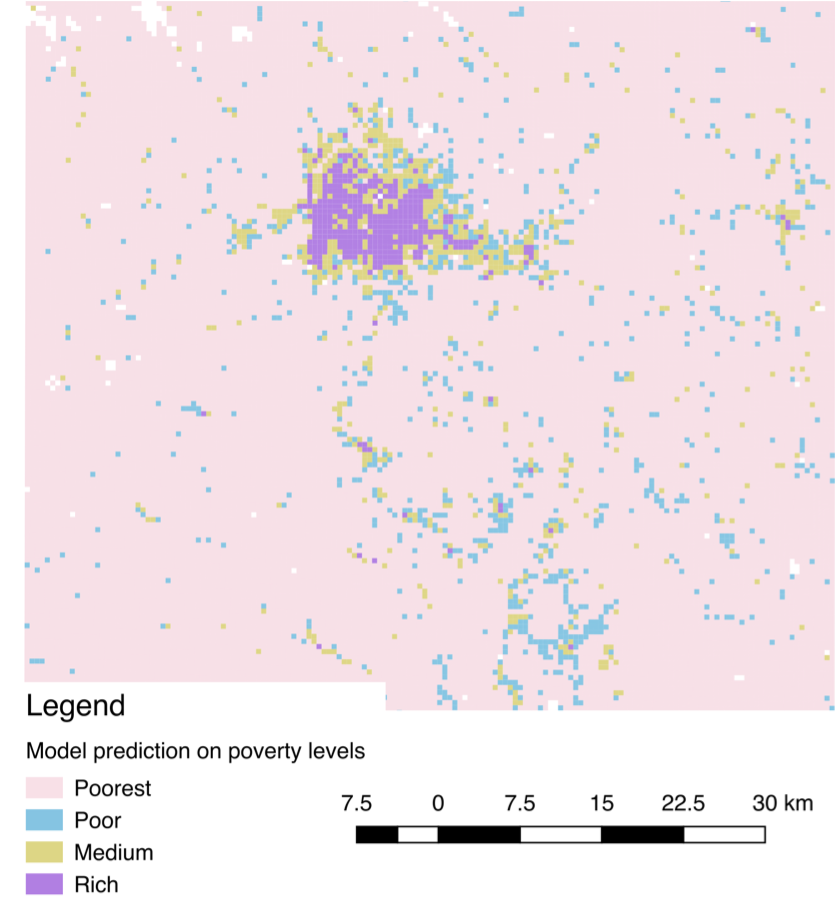

In [2]:
from IPython.display import Image
Image('figures/poverty detection1.png')